## 2D Boussinesq (buoyancy-driven) flow example

### equations solved:

$$
\partial_t \theta + ...
$$

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
from open_atmos_jupyter_utils import show_plot
from open_atmos_jupyter_utils.show_anim import show_anim
from PyMPDATA import Options,ScalarField,VectorField,Solver,Stepper
from matplotlib import colors, pyplot
from PyMPDATA.boundary_conditions import Periodic
from PyMPDATA_examples.Jaruga_et_al_2015.temp import *
import numpy as np
from numba import jit
import warnings
import ipywidgets
from numba.core.errors import NumbaExperimentalFeatureWarning
from PyMPDATA.impl.enumerations import IMPL_META_AND_DATA, META_AND_DATA_DATA, IMPL_BC

## non-JIT-compilable (yet) functions

In [3]:
_U = 0
_W = 1
_T = 2

@jit
def data(impl):
    return impl[IMPL_META_AND_DATA][META_AND_DATA_DATA]

#@jit
def calc_gc_extrapolate_in_time(solvers, stash):
    for k in (0, 1):
        stash[k].get()[:] = -.5 * stash[k].get() + 1.5 * solvers[k]
        stash[k].get()[:] = -.5 * stash[k].get() + 1.5 * solvers[k]
        xchng_pres(stash[k].impl)   

#@njit
def calc_gc_interpolate_in_space(advector: VectorField, stash: dict, dt:float, dxy: tuple):
    idx_diff = ( 
        (slice(None, -1), slice(None, None)),
        (slice(None, None), slice(None, -1)),
    )
    for axis in (0, 1):
        advector.data[axis][:] = dt / dxy[axis] * (
            np.diff(stash[axis].data, axis=axis) / 2 + stash[axis].data[idx_diff[axis]]
        )[:]

#@njit
def fill_stash(solvers, stash):
    for k in (0, 1):
        stash[k].get()[:] = solvers[k].advectee.get()
        xchng_pres(stash[k].impl)

#@njit
def ini_pressure(Phi, solvers, N, M):
    npoints = N*M
    for k in (0, 1):
        Phi.get()[:] -= 0.5 * np.power(solvers[k].advectee.get()[:],2)
    Phi_mean = np.sum(Phi.get()) / npoints
    Phi.get()[:] -= Phi_mean

#@njit    
def div(lap_tmp,dxy):
    h = lap_tmp[0].halo
    return (
        np.gradient(lap_tmp[0].data, dxy[0],axis=0) +
        np.gradient(lap_tmp[1].data, dxy[1],axis=1)
    )[h:-h,h:-h]

#@njit
def lap(Phi, dxy, err_init, lap_tmp, tmp_uvw = None):
    xchng_pres(Phi.impl)
    calc_grad([x.impl for x in lap_tmp], Phi, dxy);
    if (err_init):
        for k in (0, 1):
            lap_tmp[k].data[:] -= data(tmp_uvw[k])

    for k in (0, 1):
        xchng_pres(lap_tmp[k].impl)
        
    return div(lap_tmp, dxy)

#@njit
def pressure_solver_loop_init(err,p_err,lap_p_err,dxy,lap_tmp,tmp_uvw):
    p_err[0].get()[:] = err.get()[:]
    lap_p_err[0][:] = lap(p_err[0], dxy, False, lap_tmp,tmp_uvw)
    
##@njit
def pressure_solver_loop_body(Phi,beta,converged,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,lap_tmp):
    tmp_den = [1.]*k_iters
    alpha = [1.]*k_iters
    for v in range(0,k_iters):

          tmp_den[v] = np.sum(lap_p_err[v]**2)
          if (tmp_den[v] != 0):
              beta = - np.dot(
                  err.get().ravel(),
                  lap_p_err[v].ravel()
              ) / tmp_den[v]
          Phi.get()[:] += beta * p_err[v].get()
          err.get()[:] += beta * lap_p_err[v]

          error = max(
             abs(np.amax(err.get())),
             abs(np.amin(err.get()))
          )

          if (error <= err_tol): 
              converged = True

          lap_err[:] = lap(err, dxy, False, lap_tmp);
          
          for l in range(v):
              if (tmp_den[l] != 0):
                    alpha[l] = - np.dot(lap_err.ravel(), lap_p_err[l].ravel()) / tmp_den[l];
          if (v < (k_iters - 1)):
              p_err[v + 1].get()[:] = err.get()
              lap_p_err[v + 1][:] = lap_err[:]
              for l in range(v):
                  p_err[v + 1].get()[:] += alpha[l] * p_err[l].get()
                  lap_p_err[v + 1][:] += alpha[l] * lap_p_err[l]
          else:
              p_err[0].get()[:] = err.get()[:] + alpha[0] * p_err[0].get()
              lap_p_err[0][:] = lap_err[:] + alpha[0] * lap_p_err[0]
              for l in range(1,v+1):
                    p_err[0].get()[:] += alpha[l] * p_err[l].get()
                    lap_p_err[0][:] += alpha[l] * lap_p_err[l]
    return converged

#@njit
def pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,simple = False):
    for k in (0, 1):
         data(tmp_uvw[k])[:] = solvers[k].advectee.data
    
    #initial error
    err.get()[:] = lap(Phi, dxy, True,lap_tmp,tmp_uvw)

    iters = 0
    converged = False

    pressure_solver_loop_init(err,p_err,lap_p_err,dxy,lap_tmp,tmp_uvw)
    #pseudo-time loop
    while not converged:        
         converged = pressure_solver_loop_body(Phi,beta,converged,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,lap_tmp)
         iters += 1

         if (iters > 10000): # going beyond 10000 iters means something is really wrong,
             # usually boundary conditions but not always !
             raise Exception("stuck in pressure solver")

    xchng_pres(Phi.impl)

    calc_grad(tmp_uvw, Phi, dxy)

#@njit
def calc_grad(arg : ScalarField, Phi, dxy):
    h = Phi.halo
    idx = (slice(h,-h),slice(h,-h))
    for k in (0,1):
        data(arg[k])[idx] = np.gradient(Phi.data, dxy[k], axis=k)[idx]

## Parameters

In [4]:
# TODO: put in a named tuple or dict

outfreq = 1

N, M  = 20, 20
dxy = 2000/(N), 2000/(M)
Tht_ref = 300.
g = 9.81
r0 = 250.
dt = 7.5
nt = int(600//dt)
beta  = 0.25
prs_tol = 1e-7;
err_tol = prs_tol/dt
k_iters = 4

assert dt * nt == 600

## initial condition

In [5]:
xi, yi = np.indices((N, M))
mask = np.sqrt(((xi+1/2)*dxy[0]-1000)**2+((yi+1/2)*dxy[1]-260)**2) < r0

mesh = np.full((N,M), fill_value=Tht_ref, dtype=float)
mesh += np.where(mask, 0.5, 0)

## PyMPDATA setup

In [6]:
options = Options(n_iters=2, infinite_gauge= True,nonoscillatory = True)
bcond = (Periodic(), Periodic())

halo = options.n_halo
field_ctor_kwargs = {'halo': halo, 'boundary_conditions': bcond}

advector = VectorField(data=(np.zeros((N+1, M)), np.zeros((N, M+1))), **field_ctor_kwargs)
stepper = Stepper(options=options, grid=(N, M),n_threads = 1)

def new_sf(N, M):
    field = ScalarField(data=np.zeros((N,M)), **field_ctor_kwargs)
    field.assemble(stepper.traversals)
    return field

def new_sfs(N, M, impl=False):
    return tuple([new_sf(N,M).impl if impl else new_sf(N,M) for _ in ('u', 'w')])

solver_ctor_kwargs = {'stepper': stepper, 'advector': advector}
solvers = {
    _U: Solver(advectee=new_sf(N,M), **solver_ctor_kwargs),
    _W: Solver(advectee=new_sf(N,M), **solver_ctor_kwargs),
    _T: Solver(advectee=ScalarField(data=mesh, **field_ctor_kwargs), **solver_ctor_kwargs),
}
advectee_data = tuple([
    solvers[idx].advectee.data for idx in range(3)
])

rhs_w = np.zeros((N,M))
stash = new_sfs(N, M)
vip_rhs = new_sfs(N, M, impl=True)
Phi = new_sf(N,M)
tmp_uvw = new_sfs(N, M, impl=True)
lap_tmp = new_sfs(N, M)
lap_err = np.zeros((N,M))
err = new_sf(N,M)
p_err = [new_sf(N,M) for _ in range(k_iters)]
lap_p_err = [np.empty((N,M)) for _ in range(k_iters)]

## JIT-compilable functions

In [7]:
fill_halos_scalar = stepper.traversals._code["fill_halos_scalar"]

@jit(**options.jit_flags)
def xchng_pres(impl):
    fill_halos_scalar(0, *impl[IMPL_META_AND_DATA], impl[IMPL_BC], None)

@jit(**options.jit_flags)
def vip_rhs_apply(dt, vip_rhs, advectee_data):
     for k in (0, 1):
         advectee_data[k][:] += 0.5 * dt * data(vip_rhs[k])
         data(vip_rhs[k])[:] = 0

@jit(**options.jit_flags)
def apply_rhs(w, rhs_w : np.ndarray, dt : float):
    w += rhs_w * dt
    
@jit(**options.jit_flags)
def update_rhs(tht : np.ndarray, rhs_w : np.ndarray, tht_ref : int, g : float):
    rhs_w[:] = g * (tht - tht_ref) / tht_ref

@jit(**options.jit_flags)
def pressure_solver_apply(advectee_data, tmp_uvw):
    for k in (0, 1):
        advectee_data[k][:] -= data(tmp_uvw[k])

## Simulation loop

In [8]:
%%time

progress = ipywidgets.FloatProgress(max=nt)
display(progress)

output = []
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore",category= NumbaExperimentalFeatureWarning)

    Phi.get()[:] = 0
    pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err,simple = True)
    xchng_pres(Phi.impl)
    calc_grad(tmp_uvw, Phi, dxy)
    pressure_solver_apply(advectee_data, tmp_uvw)

    ini_pressure(Phi,solvers,N,M)
    xchng_pres(Phi.impl)
    calc_grad(tmp_uvw, Phi, dxy)
    for k in (0,1):
        data(vip_rhs[k])[:] -= data(tmp_uvw[k])

    for step in range(nt + 1):
        if step != 0:
            calc_gc_extrapolate_in_time((solvers[0].advectee.get(),solvers[1].advectee.get()), stash) # reads & writes to stash
            calc_gc_interpolate_in_space(advector, stash,dt,dxy) # reads from stash
            fill_stash(solvers, stash) # writes to stash
            apply_rhs(solvers[_W].advectee.get(), rhs_w, dt/2)

            vip_rhs_apply(dt, vip_rhs, advectee_data)
    
            for solver in solvers.values():
                solver.advance(n_steps=1)
    
            update_rhs(tht=solvers[_T].advectee.get(), rhs_w=rhs_w, g=g, tht_ref=Tht_ref)
            apply_rhs(solvers[_W].advectee.get(), rhs_w, dt/2)
    
            for k in (0,1):
                data(vip_rhs[k])[:] = -solvers[k].advectee.data
    
            pressure_solver_update(solvers,Phi,beta,lap_tmp,tmp_uvw,err,p_err,lap_p_err,dxy,k_iters,err_tol,lap_err)
            pressure_solver_apply(advectee_data, tmp_uvw)
    
            for k in (0, 1):
                data(vip_rhs[k])[:] += solvers[k].advectee.data
                data(vip_rhs[k])[:] /= 0.5 * dt
            
        if step % outfreq == 0:
            output.append(solvers[_T].advectee.get().copy())
        progress.value = step
with open("output.npy", 'wb') as f:
    np.save(f, np.array(output))

FloatProgress(value=0.0, max=80.0)

CPU times: total: 1min 36s
Wall time: 1min 46s


## Visualisation

FloatProgress(value=0.0, max=81.0)


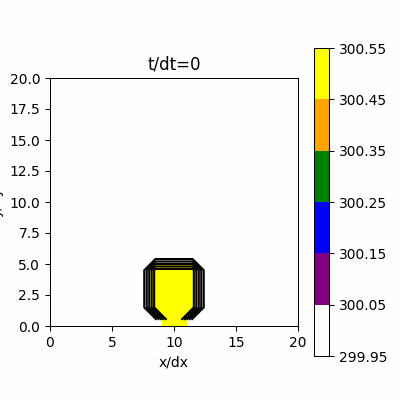

HTML(value="<a href='.\\tmpgsxuio24.gif' target='_blank'>.\\tmpgsxuio24.gif</a><br>")

In [9]:
progress = ipywidgets.FloatProgress(max=len(output))

def plot(step):
    data = output[step]
    grid = data.shape
    x, y = np.indices(grid)
    colorticks = np.linspace(299.95, 300.55, 7, endpoint=True)
    cmap = colors.ListedColormap(["white", "purple", "blue", "green","orange","yellow"])

    fig = pyplot.figure(figsize=(4,4))
    pyplot.title("t/dt="+str(step))
    pyplot.xlabel("x/dx")
    pyplot.ylabel("y/dy")
    pyplot.contour(x+1/2, y+1/2, data, levels=colorticks[1:], colors='k')
    pyplot.imshow(data.T, origin="lower", extent=(0, grid[0], 0, grid[1]), cmap=cmap, vmin=colorticks[0], vmax=colorticks[-1])
    pyplot.colorbar(ticks=colorticks)

    progress.value += 1
    return fig

display(progress)
show_anim(plot, frame_range=range(len(output)))